## 2.Demosaicing

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [4]:
bayer_mat = scipy.io.loadmat("Copy of bayer1.mat")
intensity_mat = scipy.io.loadmat("Copy of RawImage1.mat")
print(intensity_mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Sep 13 18:18:13 2016', '__version__': '1.0', '__globals__': [], 'RawImage1': array([[116, 197, 128, ...,  54,   6,   9],
       [194, 146, 179, ...,  46,  46,   0],
       [112, 187, 118, ...,  24,  18,  26],
       ...,
       [ 58,  39,  51, ...,  15,  35,  26],
       [ 32,  59,  32, ...,  14,  15,  30],
       [ 68,  26,  60, ...,   9,   7,   0]], dtype=uint8)}


In [5]:
bayer_mat1 = np.array(bayer_mat["bayer1"])
intensity_array = np.array(intensity_mat["RawImage1"])/255
print(bayer_mat1)
print(bayer_mat1.shape)

[[1 2 1 ... 2 1 2]
 [2 3 2 ... 3 2 3]
 [1 2 1 ... 2 1 2]
 ...
 [2 3 2 ... 3 2 3]
 [1 2 1 ... 2 1 2]
 [2 3 2 ... 3 2 3]]
(1128, 2048)


In [6]:
rows = bayer_mat1.shape[0]
cols = bayer_mat1.shape[1]
print(rows, cols)

1128 2048


### 1 - a - Bilinear Interpolation

### Method - 1

In [9]:
green_kernel1 = np.array([[0,1,0],[1,0,1],[0,1,0]])/4
red_kernel1 = np.array([[1,0,1],[0,0,0],[1,0,1]])/4
blue_kernel1 = np.array([[1,0,1],[0,0,0],[1,0,1]])/4
padded_array1 = np.pad(intensity_array, pad_width=1, mode='constant',constant_values=0)

green_channel1 = np.zeros((rows,cols))
red_channel1 = np.zeros((rows,cols))
blue_channel1 = np.zeros((rows,cols))  


for i in range(rows):
    for j in range(cols):
        region = padded_array1[i:i+3, j:j+3]
        if bayer_mat1[i,j] == 1:
            red_channel1[i,j] = intensity_array[i,j]
            green_channel1[i,j] = np.sum(region*green_kernel1)
            blue_channel1[i,j] = np.sum(region*blue_kernel1)
        if bayer_mat1[i,j] == 2:
            green_channel1[i,j] = intensity_array[i,j]
            red_channel1[i,j] = np.sum(region*np.array([[0,1,0],[0,0,0],[0,1,0]])/2)
            blue_channel1[i,j] = np.sum(region*np.array([[0,0,0],[1,0,1],[0,0,0]])/2)
        if bayer_mat1[i,j] == 3:
            blue_channel1[i,j] = intensity_array[i,j]
            green_channel1[i,j] = np.sum(region*green_kernel1)
            red_channel1[i,j] = np.sum(region*red_kernel1)

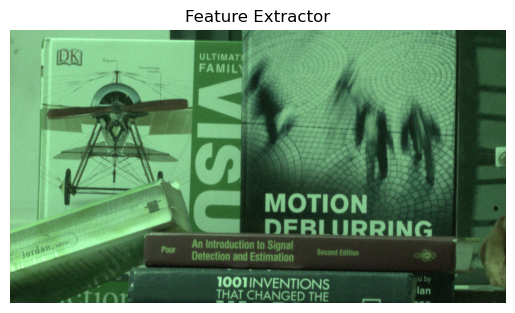

In [10]:
# print(green_channel1)
# print(red_channel1)
# print(blue_channel1)

image = np.stack((red_channel1,green_channel1,blue_channel1),axis=2)
plt.imshow(image)
plt.title("Feature Extractor")
plt.axis("Off")
plt.show()

### Method -2

In [12]:
def Bilateral2(intensity_array, bayer_mat):
    green_kernel1 = np.array([[0,1,0],[1,0,1],[0,1,0]])/4
    red_kernel1 = np.array([[1,0,1],[0,0,0],[1,0,1]])/4
    blue_kernel1 = np.array([[1,0,1],[0,0,0],[1,0,1]])/4
    padded_array1 = np.pad(intensity_array, pad_width=1, mode='constant',constant_values=0)
    (rows,cols) = intensity_array.shape
    green_channel1 = np.zeros((rows,cols))
    red_channel1 = np.zeros((rows,cols))
    blue_channel1 = np.zeros((rows,cols))  
    for i in range(rows):
        for j in range(cols):
            region = padded_array1[i:i+3, j:j+3]
            if bayer_mat[i,j] == 1:
                red_channel1[i,j] = intensity_array[i,j]
                green_channel1[i,j] = np.sum(region*green_kernel1)
                blue_channel1[i,j] = np.sum(region*blue_kernel1)
            if bayer_mat[i,j] == 3:
                blue_channel1[i,j] = intensity_array[i,j]
                green_channel1[i,j] = np.sum(region*green_kernel1)
                red_channel1[i,j] = np.sum(region*red_kernel1)

    for i in range(rows-2):
        for j in range(cols-2):
            region_red = red_channel1[i:i+3, j:j+3]
            region_blue = blue_channel1[i:i+3, j:j+3]  
            if bayer_mat[i,j] == 2:
                green_channel1[i,j] = intensity_array[i,j]
                red_channel1[i,j] = np.sum(region_red*green_kernel1)
                blue_channel1[i,j] = np.sum(region_blue*green_kernel1)
                
    return red_channel1, green_channel1, blue_channel1

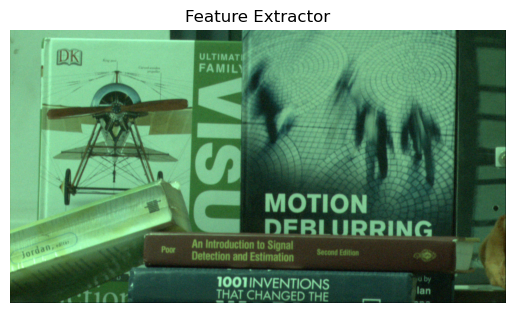

In [134]:
# print(green_channel1)
# print(red_channel1)
# print(blue_channel1)
red_channel1, green_channel1, blue_channel1 = Bilateral2(intensity_array,bayer_mat1)
rgb_1 = np.stack((red_channel1,green_channel1,blue_channel1),axis=2)
plt.imshow(rgb_1)
plt.title("Feature Extractor")
plt.axis("Off")
plt.show()

## Using in-built python funtion (1-C)

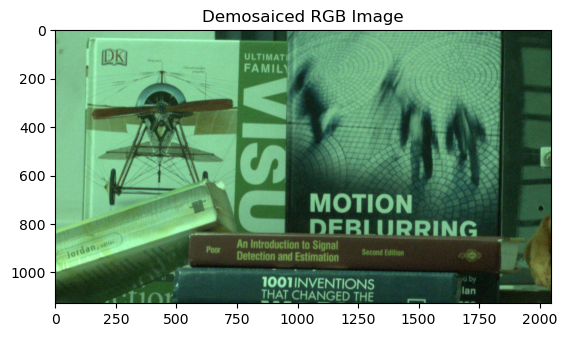

In [168]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def demosaic_rggb_array(bayer_image):
    # Ensure the Bayer image is in the correct format
    # Convert the Bayer pattern image from a NumPy array to a proper format if needed
    bayer_image = np.array(bayer_image, dtype=np.uint8)

    # Demosaic the image using OpenCV
    rgb_image = cv2.cvtColor(bayer_image, cv2.COLOR_BAYER_RG2BGR)
    
    return rgb_image

rgb_image = demosaic_rggb_array(intensity_array*255)

# Display the resulting RGB image
plt.imshow(rgb_image)
plt.title('Demosaiced RGB Image')
plt.show()


### Bicubic Interpolation - (1-B)

In [17]:
import numpy as np
from scipy.ndimage import convolve

def bicubic_kernel(x, a=-0.5):
    """
    Compute the bicubic kernel value for a given x.
    """
    abs_x = np.abs(x)
    if abs_x < 1:
        return (a + 2) * abs_x**3 - (a + 3) * abs_x**2 + 1
    elif abs_x < 2:
        return a * abs_x**3 - 5 * a * abs_x**2 + 8 * a * abs_x - 4 * a
    else:
        return 0

def create_bicubic_kernel_matrix(a=-0.5):
    """
    Create a 4x4 bicubic kernel matrix.
    """
    kernel_matrix = np.zeros((4, 4))
    for i in range(-1, 3):
        for j in range(-1, 3):
            kernel_matrix[i + 1, j + 1] = bicubic_kernel(i) * bicubic_kernel(j)
    return kernel_matrix

def convolve_bicubic(image, kernel_matrix):
    """
    Convolve the image with the bicubic kernel matrix.
    """
    return convolve(image, kernel_matrix, mode='constant', cval=0.0)

def demosaic_bayer(intensity_array, bayer_matrix):
    """
    Demosaic an image from a Bayer pattern using bicubic interpolation.
    """
    height, width = intensity_array.shape
    # Initialize color channels
    R = np.zeros((height, width))
    G = np.zeros((height, width))
    B = np.zeros((height, width))
    
    for i in range(len(bayer_matrix)):
        for j in range(len(bayer_matrix[1])):
            if bayer_matrix[i][j] == 1:
                R[i][j] = intensity_array[i][j]
            elif bayer_matrix[i][j] == 2:
                G[i][j] = intensity_array[i][j]
            elif bayer_matrix[i][j] == 3:
                B[i][j] = intensity_array[i][j]
    # Create the bicubic kernel matrix
    kernel_matrix = create_bicubic_kernel_matrix()
    
    # Convolve each channel
    R_convolved = convolve_bicubic(R, kernel_matrix)
    G_convolved = convolve_bicubic(G, kernel_matrix)
    B_convolved = convolve_bicubic(B, kernel_matrix)
    
    # Normalize channels to ensure proper color balance
    R_convolved = np.clip(R_convolved, 0, 1)
    G_convolved = np.clip(G_convolved, 0, 1)
    B_convolved = np.clip(B_convolved, 0, 1)
    
    return R_convolved, G_convolved, B_convolved
R, G, B = demosaic_bayer(intensity_array, bayer_mat1)

# Stack R, G, B channels into an RGB image
rgb_1bc = np.stack([R, G, B], axis=-1)

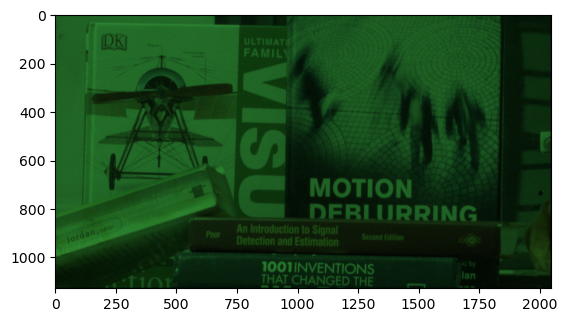

In [135]:
plt.imshow(rgb_1bc)

### 1 - D
#### When interpolating missing pixel values, the following assumptions are typically made:

#### 1) Smoothness Assumption: It is assumed that the pixel values in the image change smoothly in most regions. This means there are no abrupt changes in intensity or color over small distances.

When this assumption fails (e.g., near edges or high-frequency textures), the interpolation can result in blurred edges or artifacts, as the method cannot accurately capture sharp transitions.

#### 2) Local Consistency: The pixels surrounding the missing value are expected to have similar intensities or gradients, which are used to estimate the missing value.

If this assumption breaks down (e.g., in regions of high variance or texture), the interpolated pixel may not accurately reflect the actual scene, leading to visible inconsistencies or artifacts.

#### 3) Low Noise: It is often assumed that the image has minimal noise, and neighboring pixels accurately represent the scene's true color or intensity.

When this assumption fails (e.g., in noisy or degraded images), the interpolation might enhance noise rather than produce a smooth, 

### 1 - E

In [20]:
kodim = scipy.io.loadmat("Copy of kodim19.mat")
print(kodim)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Feb 14 13:57:00 2019', '__version__': '1.0', '__globals__': [], 'raw': array([[ 75,  95,  76, ..., 141, 135, 144],
       [ 93, 102,  90, ..., 143, 140, 142],
       [ 78,  94,  77, ..., 135, 127, 136],
       ...,
       [ 70,  41,  66, ...,  44,  68,  46],
       [ 33,  67,  60, ...,  58,  79,  71],
       [ 75,  17,  80, ...,  38,  68,  37]], dtype=uint8)}


In [21]:
kodim_bayer = scipy.io.loadmat("Copy of kodim_cfa.mat")
kodim_bayer = np.array(kodim_bayer["cfa"])
kodim_bayer

array([[1, 2, 1, ..., 2, 1, 2],
       [2, 3, 2, ..., 3, 2, 3],
       [1, 2, 1, ..., 2, 1, 2],
       ...,
       [2, 3, 2, ..., 3, 2, 3],
       [1, 2, 1, ..., 2, 1, 2],
       [2, 3, 2, ..., 3, 2, 3]], dtype=uint8)

In [22]:
intensity_kodim = kodim["raw"]

In [23]:
r_kod, g_kod, b_kod = Bilateral2(intensity_kodim/255, kodim_bayer)

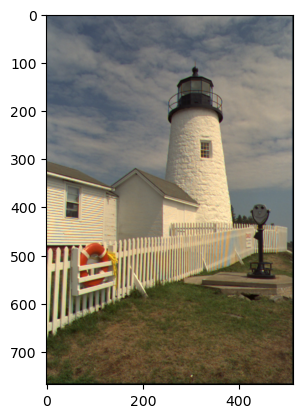

In [24]:
rgb_kodim = np.stack((r_kod, g_kod, b_kod), axis = 2)
plt.imshow(rgb_kodim)

In [25]:
R, G, B = demosaic_bayer(intensity_kodim/255, kodim_bayer)
# Stack R, G, B channels into an RGB image
rgb_image = np.stack([R, G, B], axis=-1)

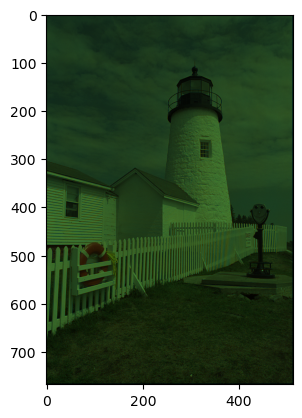

In [26]:
plt.imshow(rgb_image)

### RGB to YCrCb (1 -F)
### Using Bilinearly interpolated image

In [541]:
def rgb_to_ycrcb(rgb_image):
    rgb_image = rgb_image*255
    R, G, B = rgb_image[:, :, 0], rgb_image[:,:,1], rgb_image[:,:,2]
    Y = 0.299*R + 0.587*G + 0.114*B
    Pb = -0.168736*R - 0.331264*G + 0.5*B
    Pr = 0.5*R - 0.418688*G - 0.081312*B
    
    return Y, Pr+127, Pr+127

In [543]:
rgb_kodim.shape

(768, 512, 3)

(-0.5, 511.5, 767.5, -0.5)

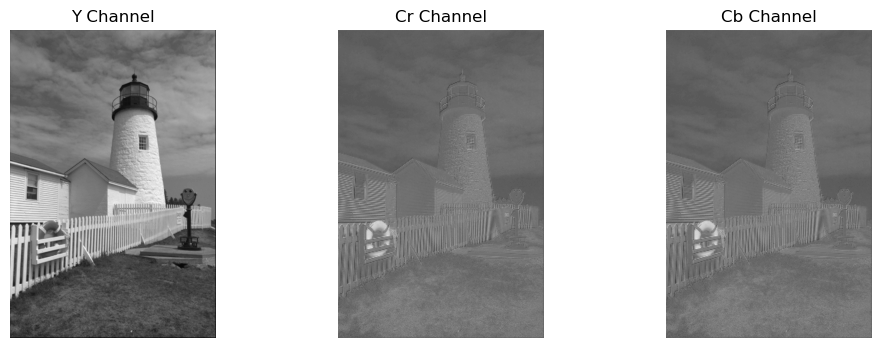

In [545]:
Y,Cr,Cb = rgb_to_ycrcb(rgb_kodim)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Y Channel')
plt.imshow(Y, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Cr Channel')
plt.imshow(Cr, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Cb Channel')
plt.imshow(Cb, cmap='gray')
plt.axis('off')

### Using Bicubilcaly interpolated Image

(-0.5, 511.5, 767.5, -0.5)

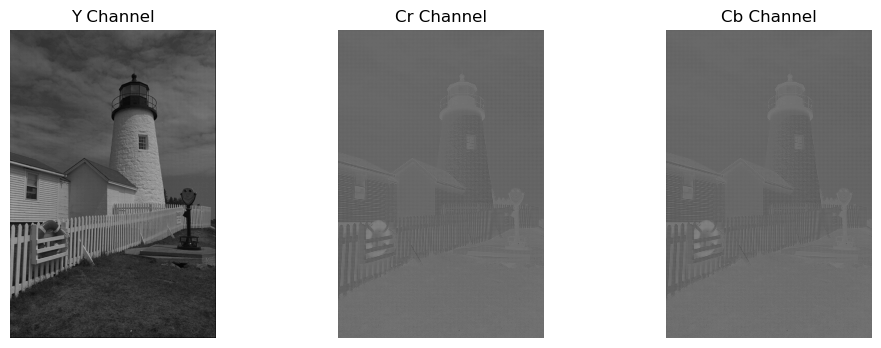

In [32]:
Y,Cr,Cb = rgb_to_ycrcb(rgb_image)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Y Channel')
plt.imshow(Y, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Cr Channel')
plt.imshow(Cr, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Cb Channel')
plt.imshow(Cb, cmap='gray')
plt.axis('off')

### Applying median filter on chrominance channels

In [547]:
def ycrcb_to_rgb(image):
    rows, cols, channels = image.shape
    image = image
    output = np.zeros((rows,cols,3))
    
    for row in range(rows):
        for col in range(cols):
            output[row, col, 0] = 1*image[row,col,0] + 1.403*(image[row,col,2]-128)
            output[row, col, 1] = 1*image[row,col,0] - 0.344*(image[row,col,1]-128) - 0.714*(image[row,col,2]-128)
            output[row, col, 2] = 1*image[row,col,0] + 1.773*(image[row,col,1]-128)
    output = np.clip(output, 0, 255)
    return output.astype(np.uint8)

In [549]:
def median_filter(channel, kernel_size):
    row, col = channel.shape    
    pad_width = int((kernel_size-1)/2)
    
    filtered_channel = np.zeros((row,col))
    padded_channel = np.pad(channel, pad_width=pad_width, mode='edge')
    
    for i in range(row):
        for j in range(col):
            region = padded_channel[i:i+pad_width,j:j+pad_width]
            filtered_channel[i,j] = np.median(region)

    return filtered_channel

In [551]:
Cr_new = median_filter(Cr, 10)
Cb_new = median_filter(Cb, 10)
YCrcb_new = np.stack((Y, Cr_new, Cb_new), axis = 2)
image_new = ycrcb_to_rgb(YCrcb_new)

(-0.5, 511.5, 767.5, -0.5)

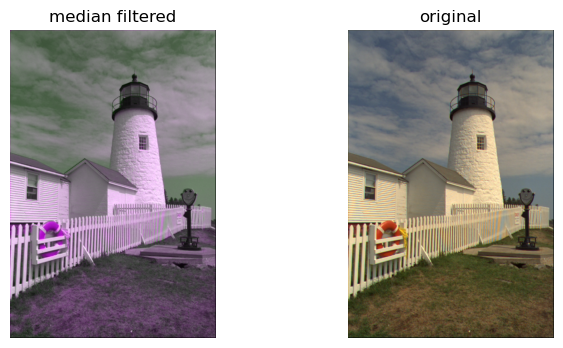

In [561]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('median filtered')
plt.imshow(image_new, cmap = 'gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('original')
plt.imshow(rgb_kodim, cmap = 'gray')
plt.axis('off')

## 2. White Balancing and Tone mapping

In [34]:
intesity_3 = scipy.io.loadmat("Copy of RawImage3.mat")
intesity_3

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Sep 14 23:53:05 2016',
 '__version__': '1.0',
 '__globals__': [],
 'RawImage3': array([[ 11,   0,  31, ..., 101,  79,  80],
        [  3,   9,   0, ...,  38, 104,   0],
        [ 34,   1,   0, ..., 107,  69,  86],
        ...,
        [255,  91, 254, ...,  47,  56,  33],
        [255, 241, 243, ...,  59,  68,  71],
        [248, 108, 255, ...,  45,  34,   0]], dtype=uint8)}

In [35]:
bayer_mat3 = scipy.io.loadmat("Copy of bayer3.mat")
bayer_mat3

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Feb 20 11:51:02 2019',
 '__version__': '1.0',
 '__globals__': [],
 'bayer3': array([[1, 2, 1, ..., 2, 1, 2],
        [2, 3, 2, ..., 3, 2, 3],
        [1, 2, 1, ..., 2, 1, 2],
        ...,
        [2, 3, 2, ..., 3, 2, 3],
        [1, 2, 1, ..., 2, 1, 2],
        [2, 3, 2, ..., 3, 2, 3]], dtype=uint8)}

In [36]:
bayer_3 = np.array(bayer_mat3["bayer3"])

intensity_arr_3 = np.array(intesity_3['RawImage3'])

In [37]:
r_3, g_3, b_3 = Bilateral2(intensity_arr_3/255, bayer_3)
r_3c, g_bc, b_bc = demosaic_bayer(intensity_arr_3/255, bayer_3)
rgb_3bc = np.stack([r_3c, g_bc, b_bc], axis=-1)
rgb_3 = np.stack((r_3, g_3, b_3), axis = 2)

(-0.5, 2027.5, 1123.5, -0.5)

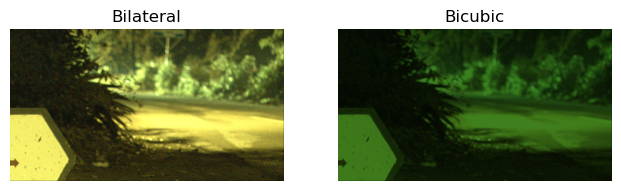

In [38]:
plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.title('Bilateral')
plt.imshow(rgb_3)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Bicubic')
plt.imshow(rgb_3bc)
plt.axis('off')

In [39]:
intensity_2 = scipy.io.loadmat("Copy of RawImage2.mat")
intensity_2

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Feb 20 11:58:58 2019',
 '__version__': '1.0',
 '__globals__': [],
 'RawImage2': array([[156, 173, 156, ..., 121,  86,  87],
        [157, 165, 145, ..., 110,  94, 100],
        [165, 170, 171, ..., 115, 103, 121],
        ...,
        [ 33,  39,  30, ..., 103,  77, 110],
        [  0,  51,  40, ..., 131,  99, 111],
        [ 17,  43,  17, ..., 108,  69,  89]], dtype=uint8)}

In [40]:
bayer_2_arr =  scipy.io.loadmat("Copy of bayer2.mat")
bayer_2_arr

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Feb 20 11:58:58 2019',
 '__version__': '1.0',
 '__globals__': [],
 'bayer2': array([[2, 1, 2, ..., 1, 2, 1],
        [3, 2, 3, ..., 2, 3, 2],
        [2, 1, 2, ..., 1, 2, 1],
        ...,
        [3, 2, 3, ..., 2, 3, 2],
        [2, 1, 2, ..., 1, 2, 1],
        [3, 2, 3, ..., 2, 3, 2]], dtype=uint8)}

In [41]:
intensity_arr_2 = np.array(intensity_2["RawImage2"])
bayer_2 = np.array(bayer_2_arr['bayer2'])

In [42]:
r_2, g_2, b_2 = Bilateral2(intensity_arr_2/255, bayer_2)
r_2c, g_2c, b_2c = demosaic_bayer(intensity_arr_2/255, bayer_2)
rgb_2bc = np.stack([r_2c, g_2c, b_2c], axis=-1)
rgb_2 = np.stack((r_2, g_2, b_2), axis = 2)

(-0.5, 1999.5, 999.5, -0.5)

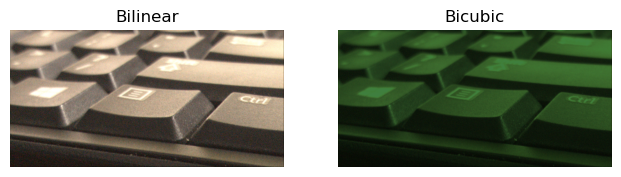

In [221]:
plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.title('Bilinear')
plt.imshow(rgb_2)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Bicubic')
plt.imshow(rgb_2bc)
plt.axis('off')

### 3-a
### Grey World Algorithm
#### Find average of all three channnels and bring all channel's average to this 

In [45]:
def white_balencing_greyworld(rgb_image, method):
    red = rgb_image[:,:,0].mean()
    green = rgb_image[:,:,1].mean()
    blue = rgb_image[:,:,2].mean()
    average = (red+green+blue)/3
    if method == 'average':
        r_new = rgb_image[:,:,0]*(average/red)
        g_new = rgb_image[:,:,1]*(average/green)    
        b_new = rgb_image[:,:,2]*(average/blue)
    elif method == 'brightest':
        r_new = rgb_image[:,:,0]*(max(red, green, blue)/red)
        g_new = rgb_image[:,:,1]*(max(red, green, blue)/green)    
        b_new = rgb_image[:,:,2]*(max(red, green, blue)/blue)
    elif method == 'inc_brightness':
        r_new = rgb_image[:,:,0]*((average/red)+0.5)
        g_new = rgb_image[:,:,1]*((average/green)+0.5)
        b_new = rgb_image[:,:,2]*((average/blue)+0.5)
    
    return np.stack((r_new, g_new, b_new), axis = 2)

#### Image - 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2047.5, 1127.5, -0.5)

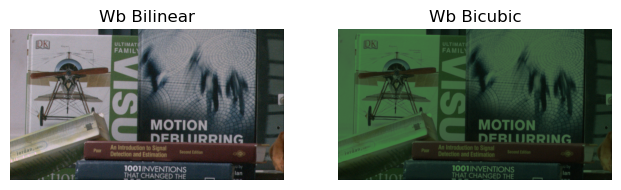

In [47]:
wb_bil1 = white_balencing_greyworld(rgb_1, 'average')
wb_bc1 = white_balencing_greyworld(rgb_1bc, 'inc_brightness')

plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.title('Wb Bilinear')
plt.imshow(wb_bil1)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Wb Bicubic')
plt.imshow(wb_bc1)
plt.axis('off')

#### Image - 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1999.5, 999.5, -0.5)

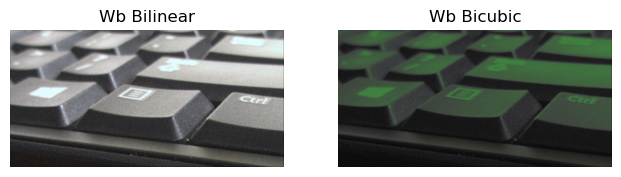

In [49]:
wb_bil2 = white_balencing_greyworld(rgb_2, 'average')
wb_bc2 = white_balencing_greyworld(rgb_2bc, 'brightest')

plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.title('Wb Bilinear')
plt.imshow(wb_bil2)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Wb Bicubic')
plt.imshow(wb_bc2)
plt.axis('off')

#### Image-3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2027.5, 1123.5, -0.5)

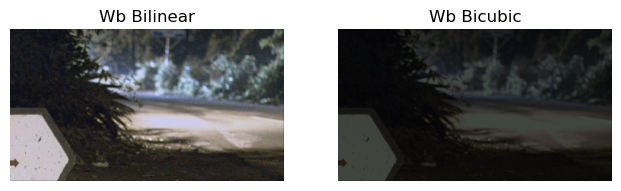

In [51]:
wb_bil3 = white_balencing_greyworld(rgb_3, 'average')
wb_bc3 = white_balencing_greyworld(rgb_3bc, 'average')

plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.title('Wb Bilinear')
plt.imshow(wb_bil3)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Wb Bicubic')
plt.imshow(wb_bc3)
plt.axis('off')

### 3 - B
### White patch alogorithm

In [54]:
def white_balencing_whitepatch(rgb_image, x, y):
    r_ratio = 1/(rgb_image[:,:,0][x][y]+0.01)
    g_ratio = 1/(rgb_image[:,:,1][x][y]+0.01)
    b_ratio = 1/(rgb_image[:,:,2][x][y]+0.01)
    
    r_new =  rgb_image[:,:,0]*r_ratio
    g_new =  rgb_image[:,:,1]*g_ratio    
    b_new =  rgb_image[:,:,2]*b_ratio
    
    return np.stack((r_new, g_new, b_new), axis = 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2047.5, 1127.5, -0.5)

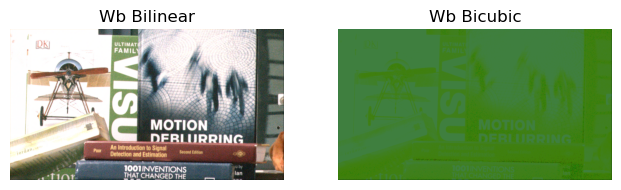

In [55]:
wb_bil_wp1 = white_balencing_whitepatch(rgb_1, 814, 830)
wb_bc_wp1 = white_balencing_whitepatch(rgb_1bc, 814, 830)

plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.title('Wb Bilinear')
plt.imshow(wb_bil_wp1)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Wb Bicubic')
plt.imshow(wb_bc_wp1)
plt.axis('off')

#### 2-b-ii

In [57]:
rgb_2.shape

(1000, 2000, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1999.5, 999.5, -0.5)

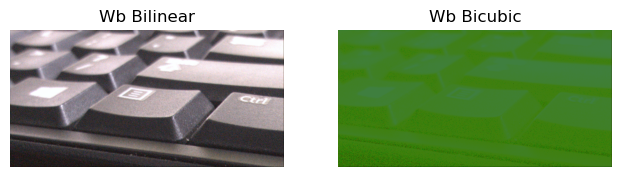

In [58]:
wb_bil_wp2 = white_balencing_whitepatch(rgb_2, 280, 1165)
wb_bc_wp2 = white_balencing_whitepatch(rgb_2bc, 280, 1165)

plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.title('Wb Bilinear')
plt.imshow(wb_bil_wp2)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Wb Bicubic')
plt.imshow(wb_bc_wp2)
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2027.5, 1123.5, -0.5)

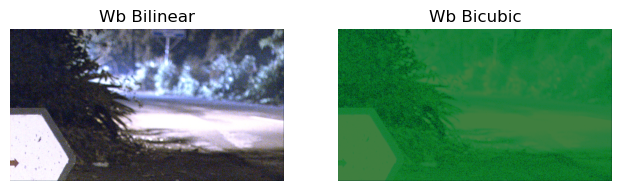

In [59]:
wb_bil_wp3 = white_balencing_whitepatch(rgb_3, 675,175)
wb_bc_wp3 = white_balencing_whitepatch(rgb_3bc, 675,175)

plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.title('Wb Bilinear')
plt.imshow(wb_bil_wp3)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Wb Bicubic')
plt.imshow(wb_bc_wp3)
plt.axis('off')

### 3-C
### Neutral scence

In [61]:
def white_balencing_neutral(rgb_image, x, y):
    r = rgb_image[:,:,0][x][y]
    g = rgb_image[:,:,1][x][y]
    b = rgb_image[:,:,2][x][y]
    
    r_new =  rgb_image[:,:,0]*(max(r,g,b)/(r+0.01))
    g_new =  rgb_image[:,:,1]*(max(r,g,b)/(g+0.01))    
    b_new =  rgb_image[:,:,2]*(max(r,g,b)/(b+0.01))
    
    return np.stack((r_new, g_new, b_new), axis = 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2047.5, 1127.5, -0.5)

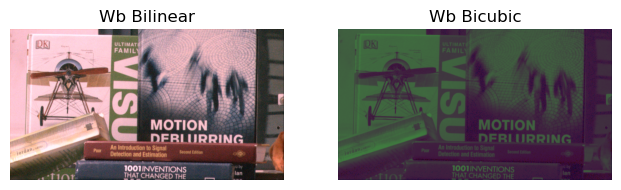

In [62]:
wb_bil_n1 = white_balencing_neutral(rgb_1, 435, 2000)
wb_bc_n1 = white_balencing_neutral(rgb_1bc, 435, 2000)

plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.title('Wb Bilinear')
plt.imshow(wb_bil_n1)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Wb Bicubic')
plt.imshow(wb_bc_n1)
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1999.5, 999.5, -0.5)

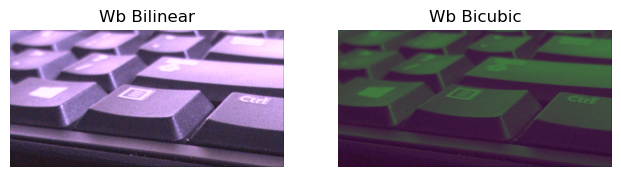

In [63]:
wb_bil_n2 = white_balencing_neutral(rgb_2, 715, 445)
wb_bc_n2 = white_balencing_neutral(rgb_2bc, 715, 445)

plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.title('Wb Bilinear')
plt.imshow(wb_bil_n2)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Wb Bicubic')
plt.imshow(wb_bc_n2)
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2027.5, 1123.5, -0.5)

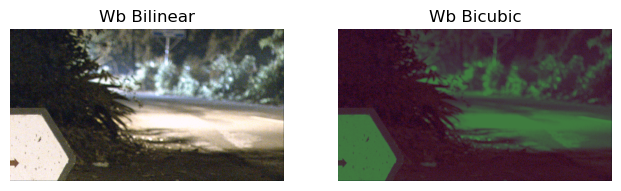

In [64]:
wb_bil_n3 = white_balencing_neutral(rgb_3, 565, 1550)
wb_bc_n3 = white_balencing_neutral(rgb_3bc, 565, 1550)

plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.title('Wb Bilinear')
plt.imshow(wb_bil_n3)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Wb Bicubic')
plt.imshow(wb_bc_n3)
plt.axis('off')

### Question - 3-d- Tone Mapping

### 3-d-i
### Histogram Equalization


In [67]:
def hist_eq(rgb):
    r = (rgb[:,:,0]*255).astype(np.uint8)
    r_new = cv2.equalizeHist(r)
    
    g = (rgb[:,:,1]*255).astype(np.uint8)
    g_new = cv2.equalizeHist(g)
    
    b = (rgb[:,:,2]*255).astype(np.uint8)
    b_new = cv2.equalizeHist(b)
    
    rgb_new = np.stack((r_new, g_new, b_new), axis = 2)
    
    plt.figure(figsize=(12, 12))

    plt.subplot(1, 3, 1)
    plt.title('Histogram equalised')
    plt.imshow(rgb_new)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('normal')
    plt.imshow(rgb)
    plt.axis('off')

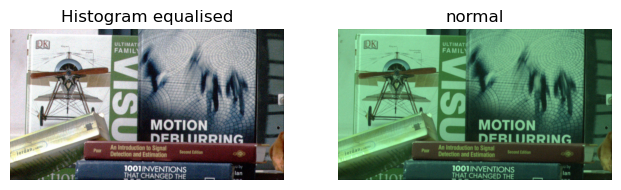

In [68]:
hist_eq(rgb_1)

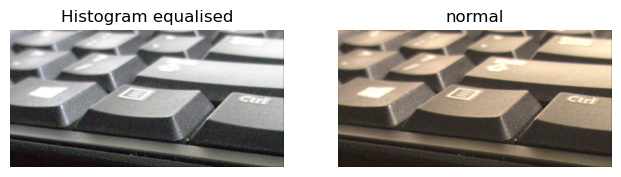

In [69]:
hist_eq(rgb_2)

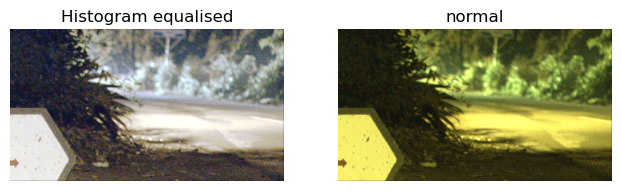

In [70]:
hist_eq(rgb_3)

### 3-D-ii
### Gamma correction

In [346]:
def gamma_corr(rgb):
    Y, Cr, Cb = rgb_to_ycrcb(rgb)
    Y_1 = np.array(Y**0.5)
    Y_2 = np.array(Y**0.7)
    Y_3 = np.array(Y**0.9)
    
    plt.figure(figsize=(12, 24))

    plt.subplot(1, 3, 1)
    plt.title('gamma = 0.5')
    plt.imshow(Y_1, cmap = 'grey')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('gamma = 0.7')
    plt.imshow(Y_2, cmap = 'grey')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('gamma = 0.9')
    plt.imshow(Y_3, cmap = 'grey')
    plt.axis('off')


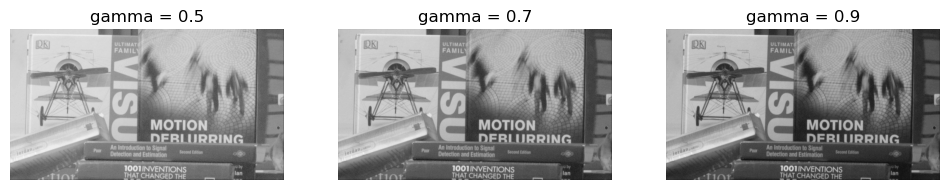

In [348]:
gamma_corr(rgb_1)

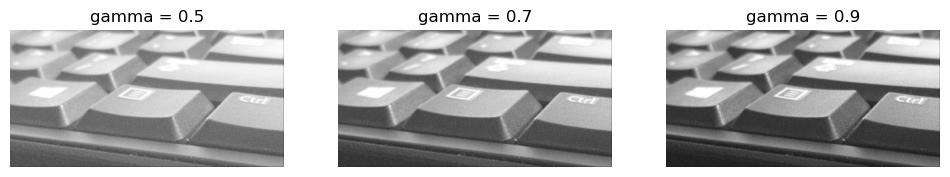

In [349]:
gamma_corr(rgb_2)

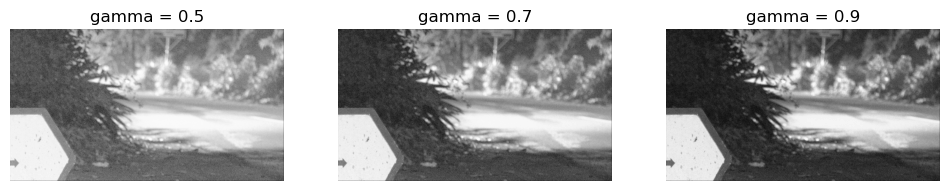

In [351]:
gamma_corr(rgb_3)

### Question 4
### Image Denoising using bilateral filter

In [320]:
import skimage.color as color

In [490]:
def bilateral_filtering(image, coordinates_top_left, coordinates_bottom_right, name="Given Image", kernel_size=11):
    image = image*255
    image = image.astype(np.uint8)
    B,G,R = cv2.split(image)
    

    x1,y1 = coordinates_top_left
    x2,y2 = coordinates_bottom_right


    sigma_n_r = np.std(R[x1:x2+1, y1:y2+1])
    sigma_n_g = np.std(G[x1:x2+1, y1:y2+1])
    sigma_n_b = np.std(B[x1:x2+1, y1:y2+1])

    sigma_s = 2.5
    sigma_r_r = 1.95 * sigma_n_r
    sigma_r_g = 1.95 * sigma_n_g
    sigma_r_b = 1.95 * sigma_n_b

    denoised_r = cv2.bilateralFilter(R, kernel_size, sigma_r_r, sigma_s)
    denoised_g = cv2.bilateralFilter(G, kernel_size, sigma_r_g, sigma_s)
    denoised_b = cv2.bilateralFilter(B, kernel_size, sigma_r_b, sigma_s)

    denoised_image = cv2.merge([denoised_b, denoised_g, denoised_r])

    plt.figure(figsize=(12,6))

    plt.subplot(2,2,1)
    plt.imshow(image[x1:x2+1, y1:y2+1])
    plt.title(f"Original Image {name} zoomed to see differences")
    plt.axis('off')

    plt.subplot(2,2,2)
    plt.imshow(denoised_image[x1:x2+1, y1:y2+1])
    plt.title(f"Denoised Image zoomed to see differences")
    plt.axis('off')

    plt.subplot(2,2,3)
    plt.imshow(image)
    plt.title(f"Original Image {name}")
    plt.axis('off')

    plt.subplot(2,2,4)
    plt.imshow(denoised_image)
    plt.title(f"Denoised Image")
    plt.axis('off')


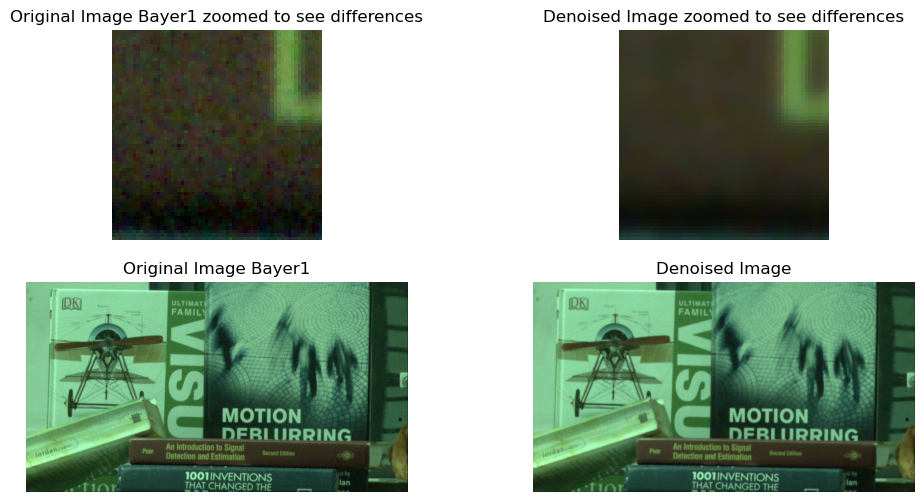

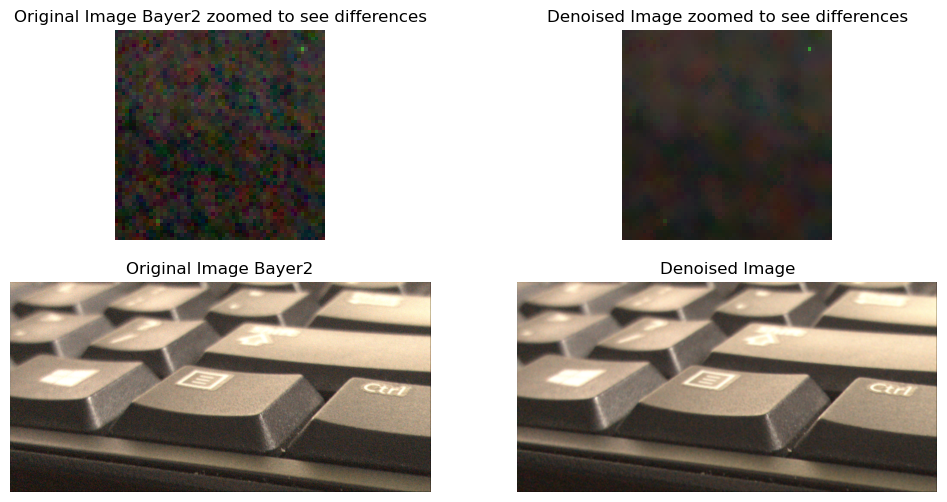

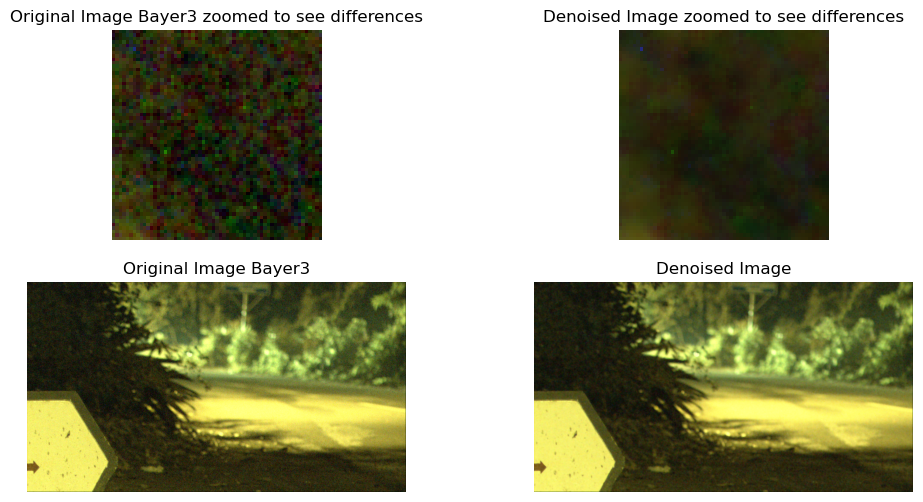

In [531]:
bileteral_filtered_image_2 = bilateral_filtering(rgb_1, name="Bayer1", coordinates_top_left=[924,705], coordinates_bottom_right=[984,765])
bileteral_filtered_image_3 = bilateral_filtering(rgb_2, name="Bayer2", coordinates_top_left=[924,705], coordinates_bottom_right=[984,765])
bileteral_filtered_image_1 = bilateral_filtering(rgb_3, name="Bayer3", coordinates_top_left=[924,705], coordinates_bottom_right=[984,765])


### Question 4.1.1

- For a gaussian function:
    - *68%* of all data in lies within 1 Standard Deviation of the Mean
$
\mu \pm \sigma
$
    - *95%* of all data in lies within 1 Standard Deviation of the Mean
$
\mu \pm 2\sigma
$
    - *99.7%* of all data in lies within 1 Standard Deviation of the Mean
$
\mu \pm 3\sigma
$

### Question 4.1.2

- So, a good approximation would be to just truncate the kernel to use $\mu \pm 2\sigma$
#### Case 1:
$$\sigma_r <= \sigma_n$$ 
- The filter becomes too sensitive to changes in intensity around the point in consideration.
- It will lead to blurring of edges also which is not intended.

#### Case 2:
$$\sigma_r >> \sigma_n$$
- The filter becomes too lenient to changes in intensity around the point in consideration.
- It will lead to almost neglecting the intensity differences and the filter would essentially become a *Spacial Gaussian Filter* which is also not intended.

### Question 5

In [468]:
def dof(v, f, N, w):
    u = v*f/(v-f)
    D_a = f/N
    
    Low_limit = (D_a*u)/(D_a+w)

    dof_ll = (Low_limit*f)/(Low_limit-f)
    
    upper_limit = (D_a*u)/(D_a-w)
    dof_ul = (upper_limit*f)/(upper_limit-f)
    
    print(f"dof is {abs(dof_ul - dof_ll)}")
    print(f"Boundry distances are ({dof_ll},{dof_ul})")
    

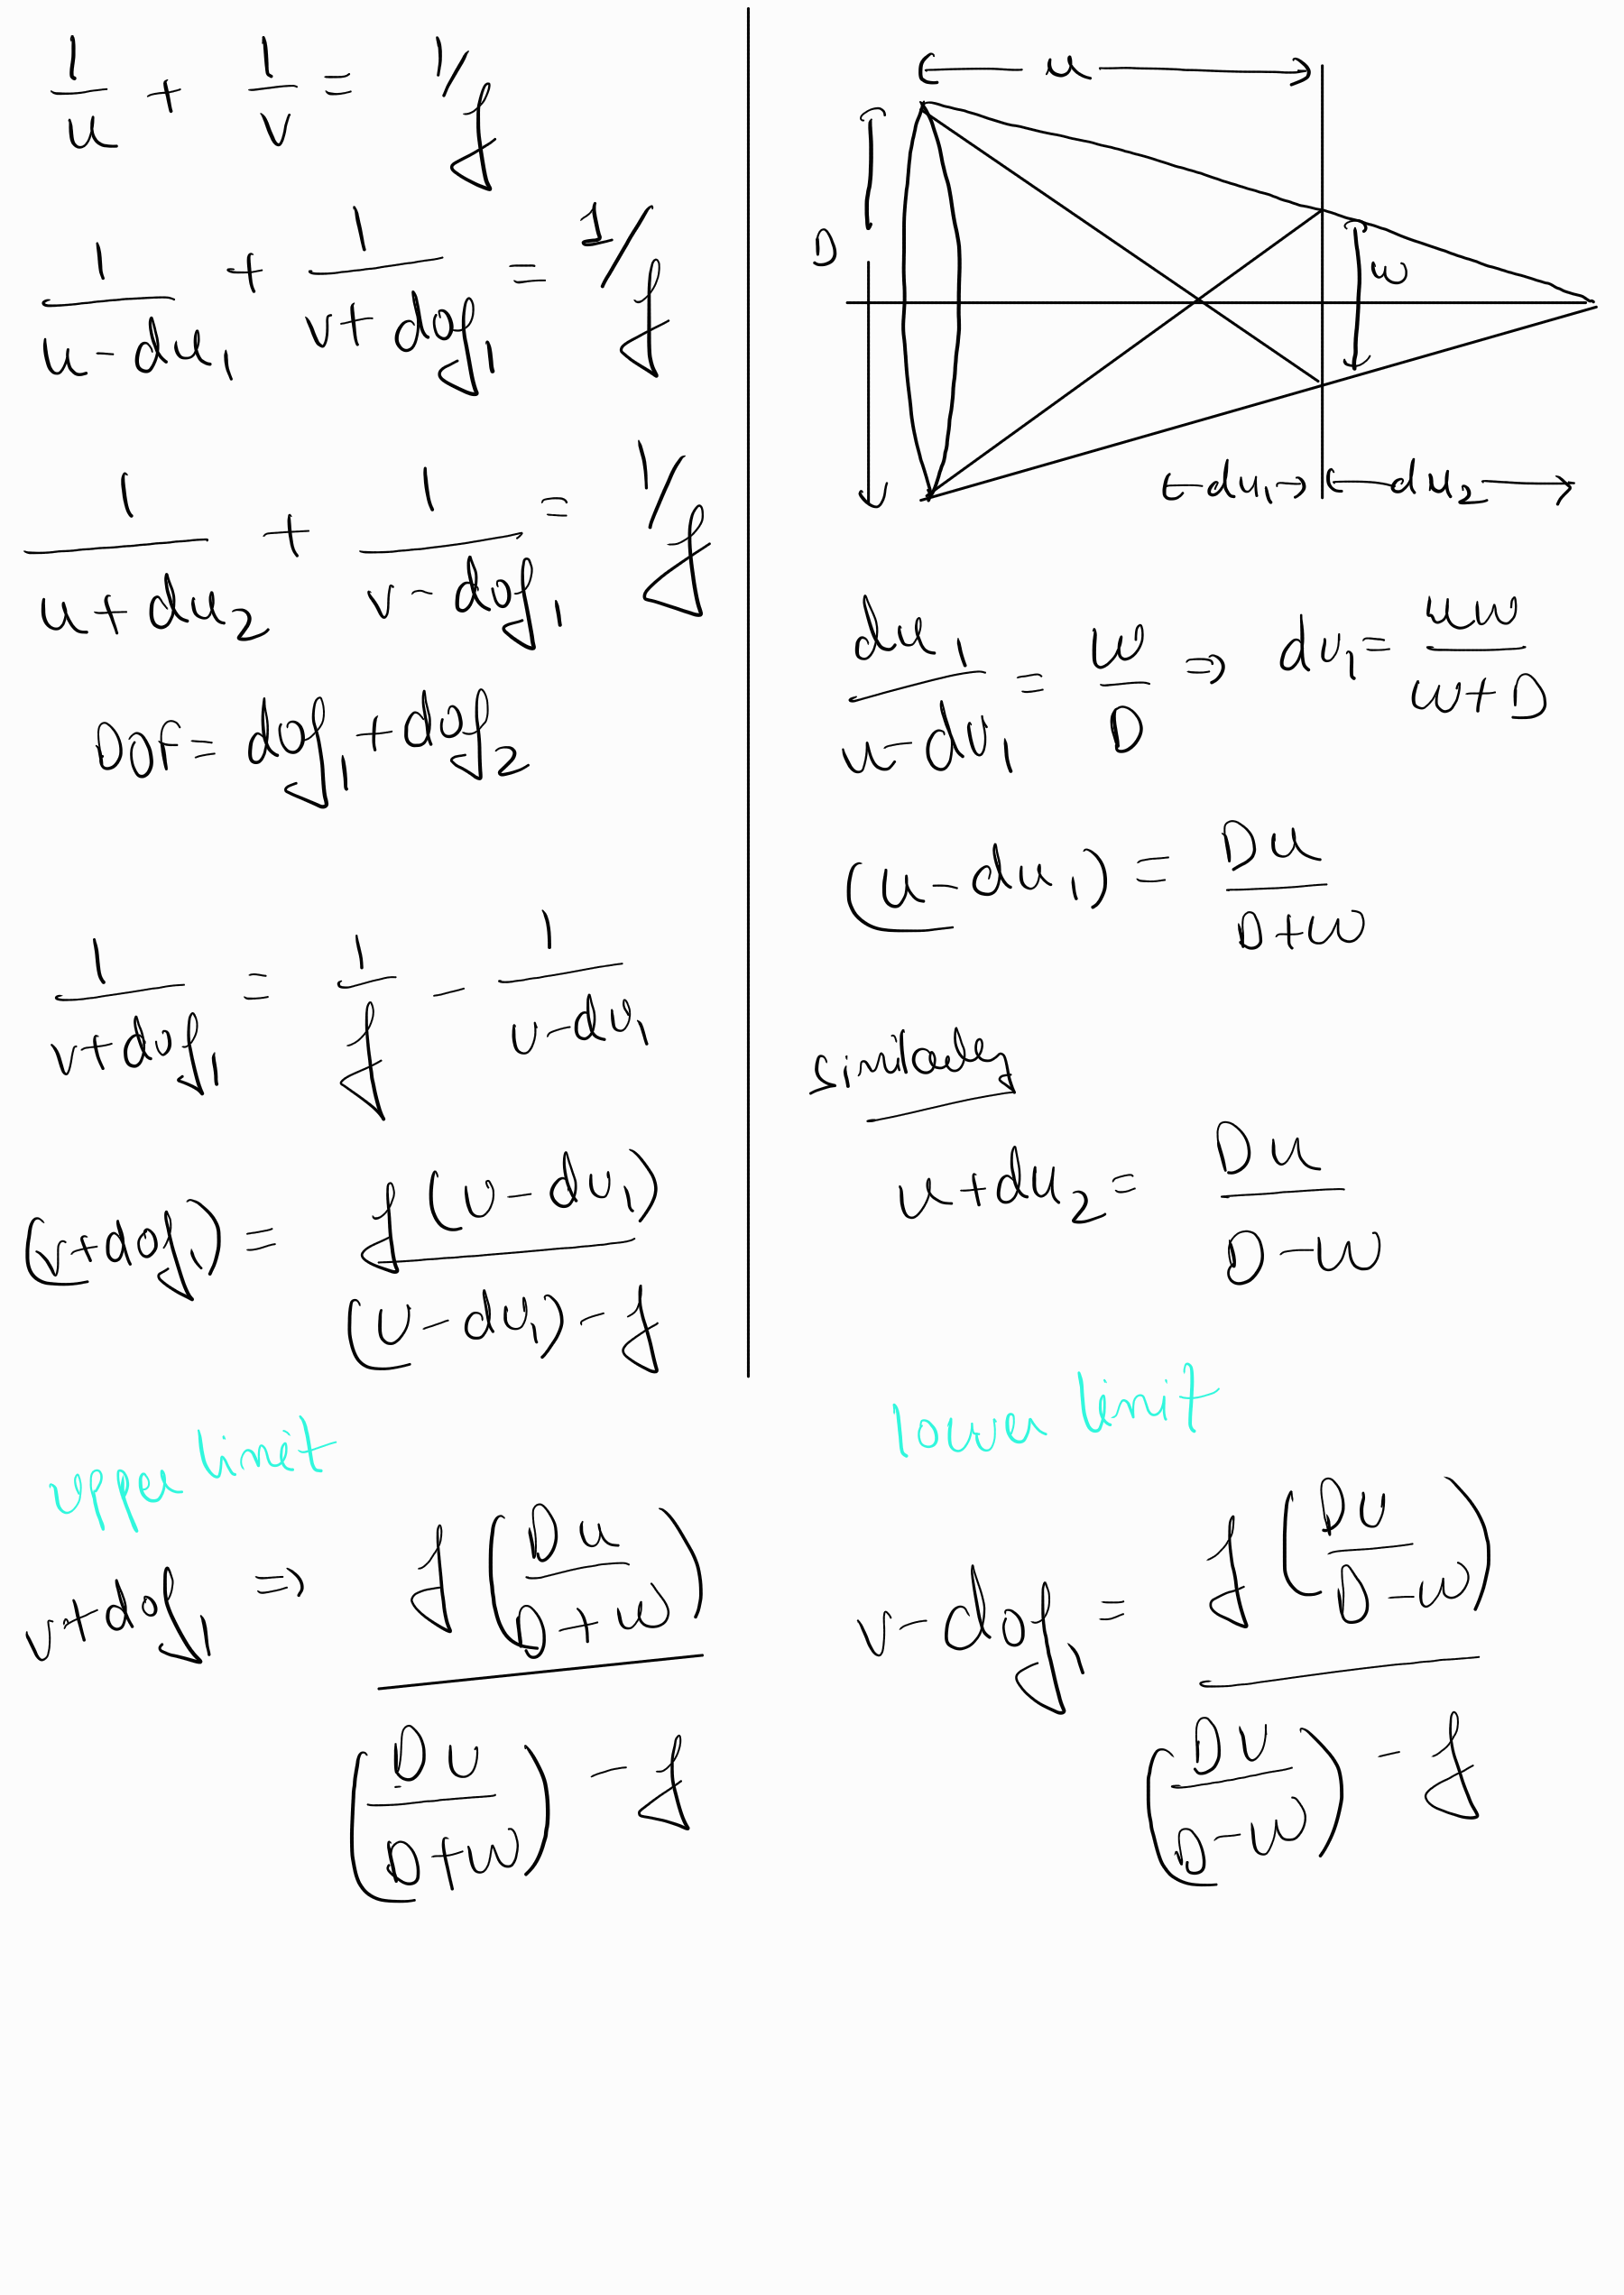

In [593]:
from IPython.display import Image, display

# Display an image from a file
display(Image(filename='page_2.png'))


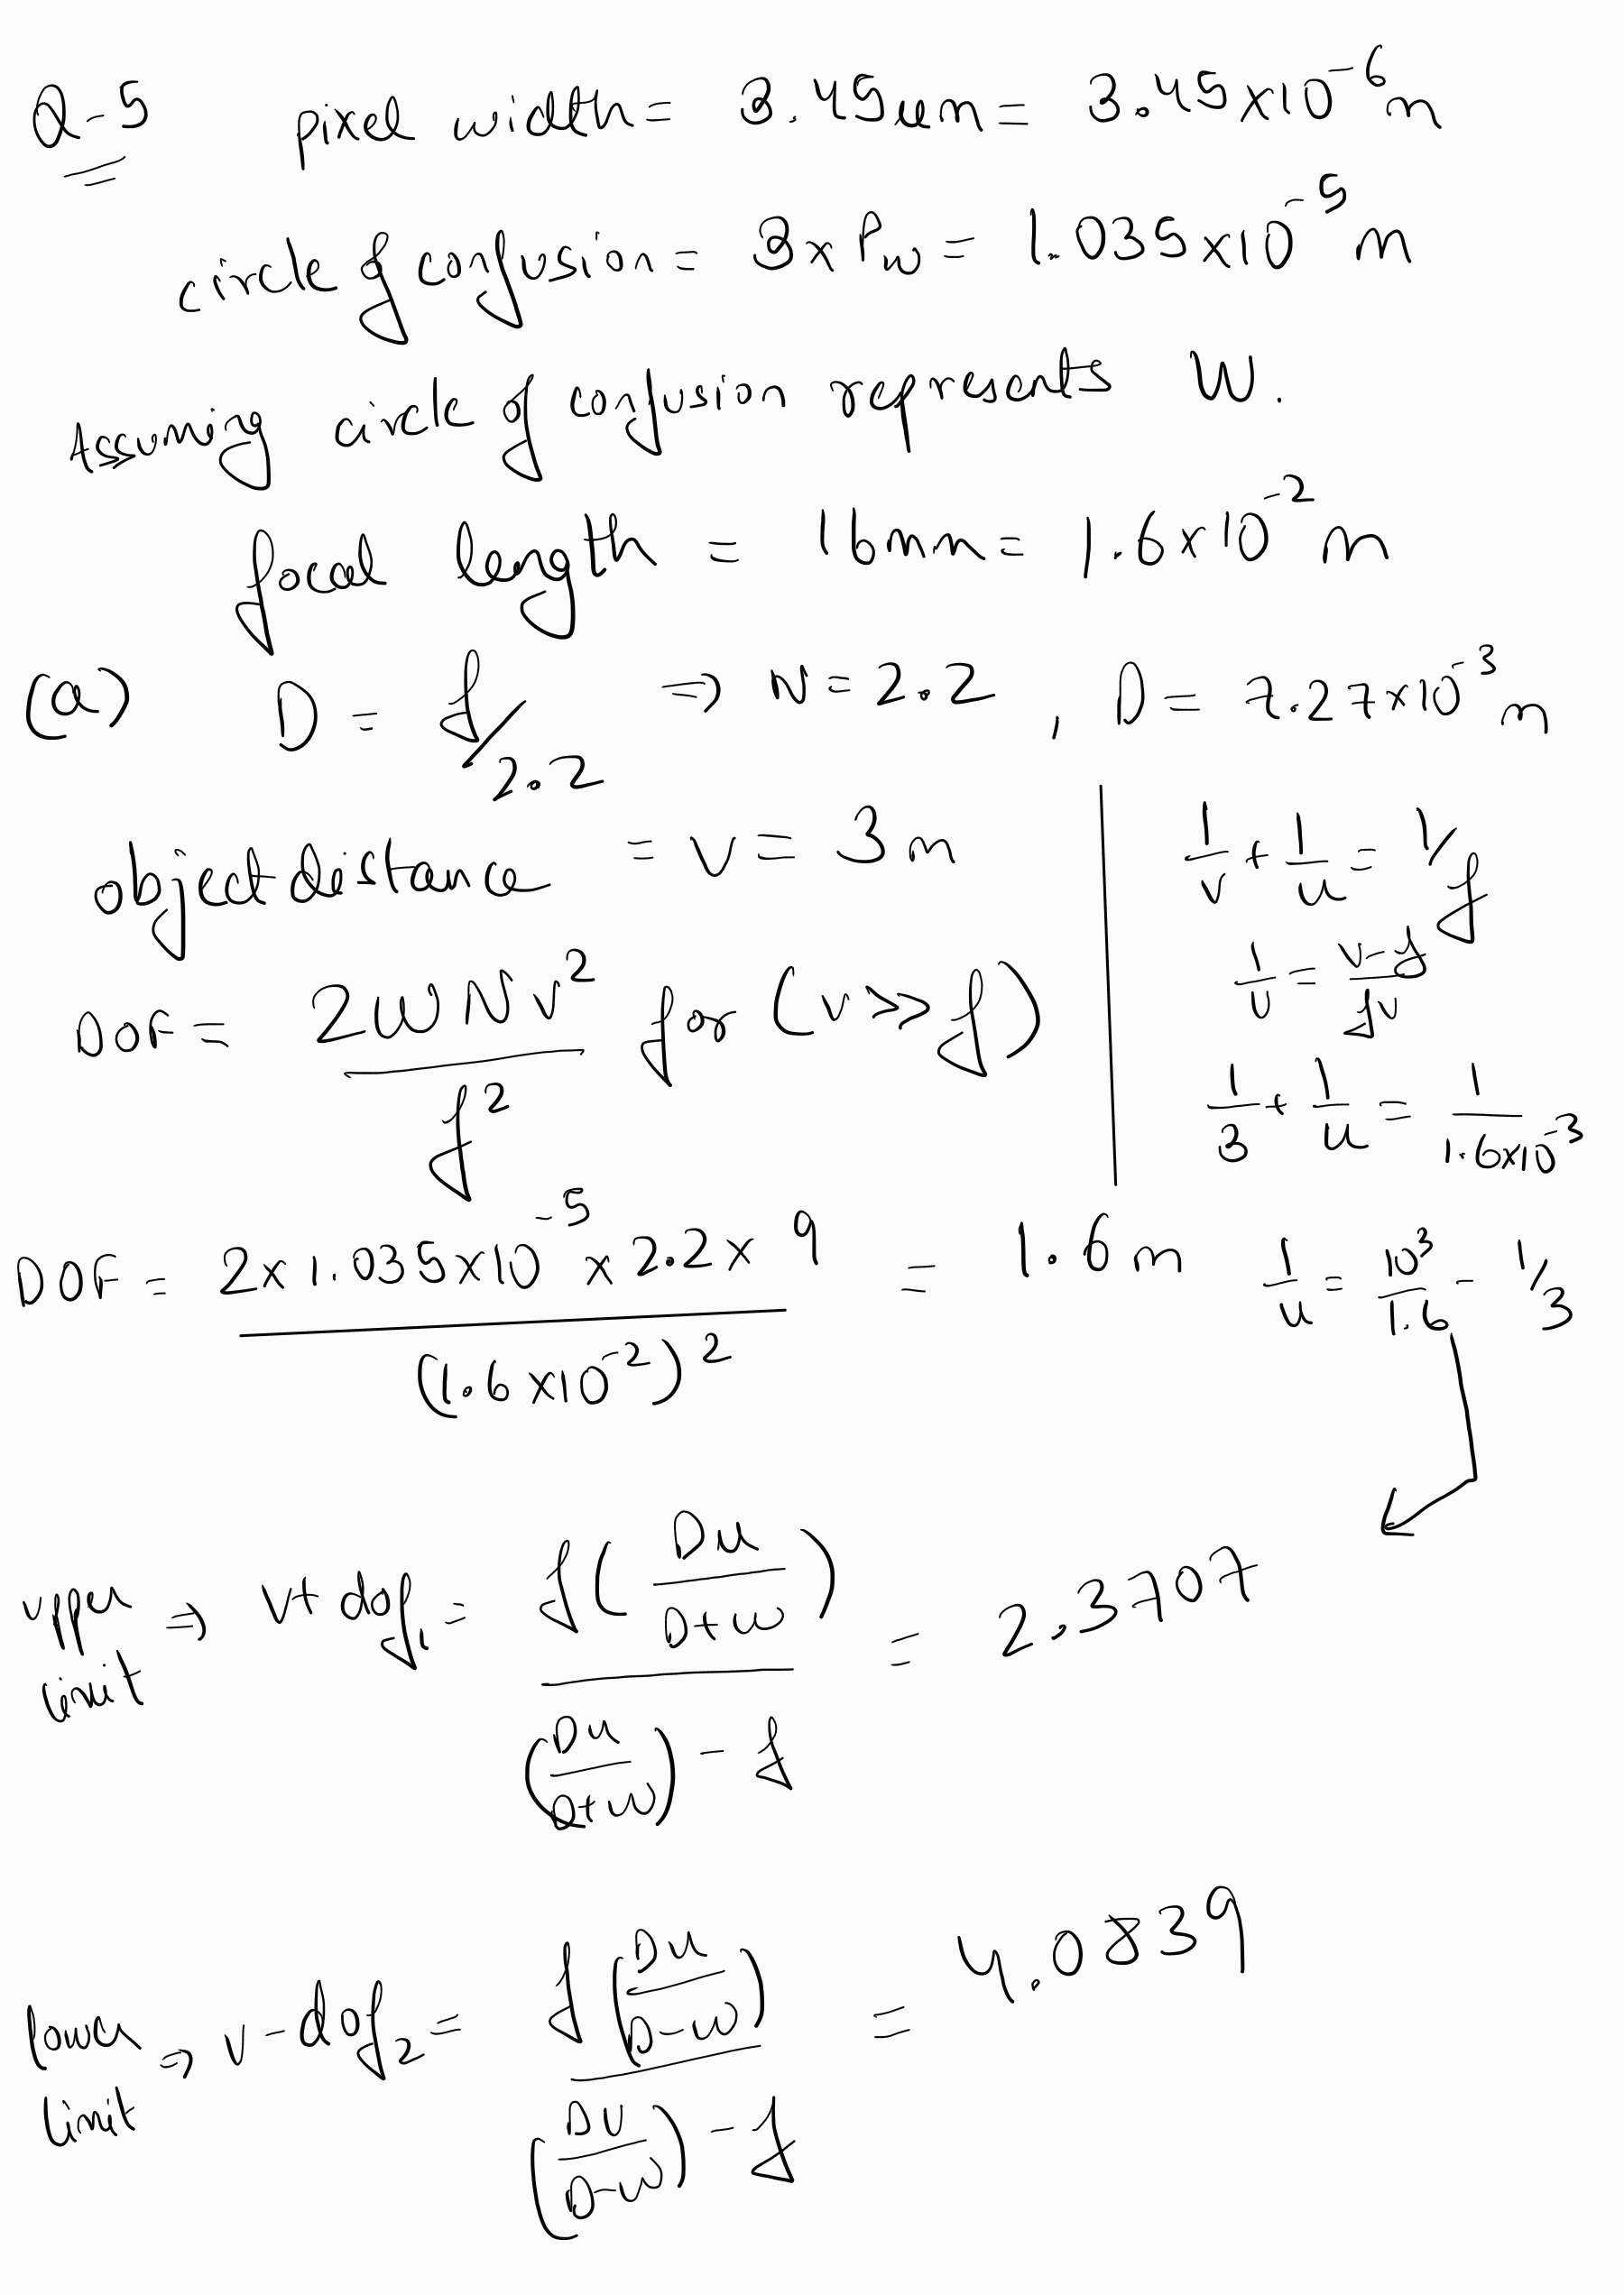

In [598]:
display(Image(filename='page3.png'))

In [515]:
dof(3, 0.016, 2.2, 0.00001035)

dof is 1.7131585490858097
Boundry distances are (4.083926388928563,2.3707678398427534)


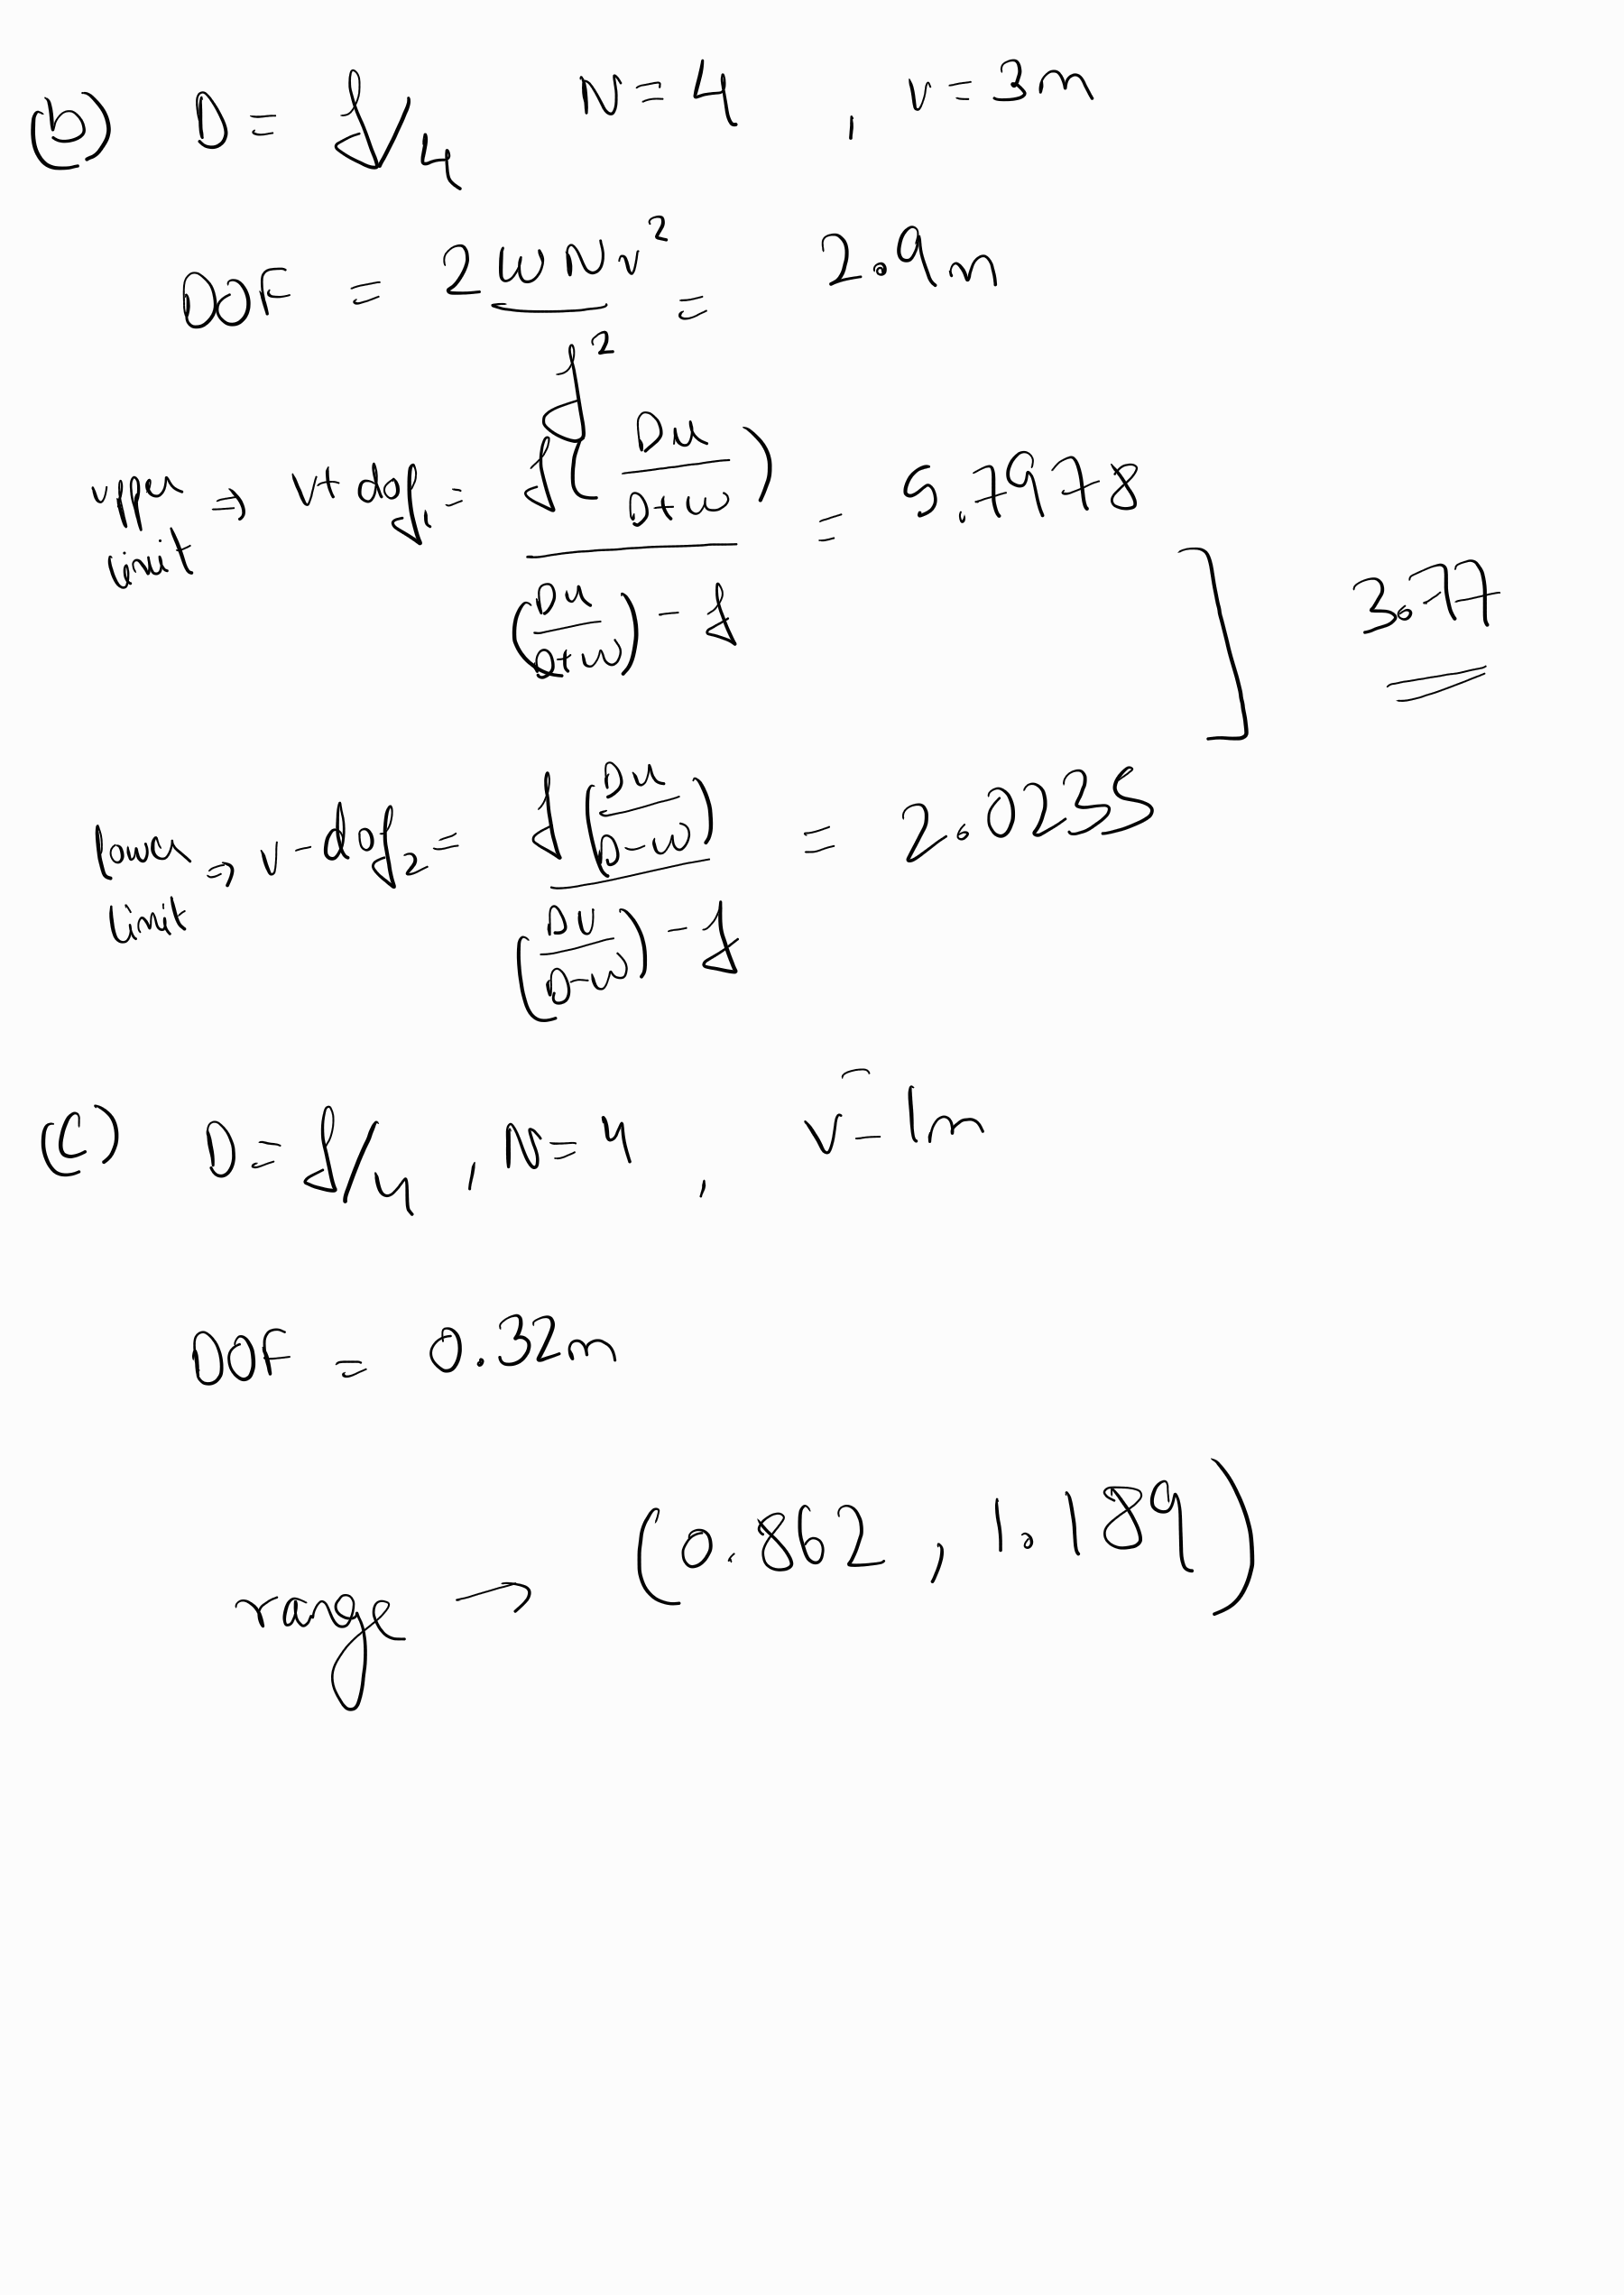

In [600]:
display(Image(filename='page_1.png'))

In [517]:
dof(3, 0.016, 4, 0.00001035)

dof is 3.7743567681845462
Boundry distances are (5.797871697930624,2.023514929746078)


In [519]:
dof(1, 0.016, 4, 0.00001035)

dof is 0.32653116869544163
Boundry distances are (1.189246240866949,0.8627150721715074)


###  Using the the derived expression leads to exact range,
###  The formula used for directly calculating the DOF has several assumptions there the range is sometimes greater or smaller than it

## By comparing we can see that by increasing v, dof increses

## Also by decreaing aperture ,dof increses